# Final project - MovieLens recommendation

In [2]:

import numpy as np
import pandas as pd
import scipy.sparse
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import lightfm
from lightfm import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import shutil
import sys
import itertools
import warnings
warnings.filterwarnings('ignore')
import time

# Data Description
## large data

In [3]:
original = pd.read_csv(('./ml-20m/ratings.csv'), header=0)
original.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
n_users = original.userId.unique().shape[0]
n_items = original.movieId.unique().shape[0]
sparsity = float(original.shape[0]) / float(n_users*n_items) * 100

print("In the original data, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (original.shape[0], n_users, n_items, sparsity))

In the original data, there are 20000263 rating events from 138493 users and 26744 movies (sparsity: 0.540%)


# FM

## Data processing

In [3]:
dataset = original  
n_users = dataset.userId.unique().shape[0]
n_items = dataset.movieId.unique().shape[0]
sparsity = float(dataset.shape[0]) / float(n_users*n_items) * 100
print("Before filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (dataset.shape[0], n_users, n_items, sparsity))

Before filtering, there are 20000263 rating events from 138493 users and 26744 movies (sparsity: 0.540%)


In [5]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count
def filter_triplets(tp, min_uc=0, min_sc=0):
    # Only keep the triplets for items which were rated by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who rated at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

Only keep items that are rated by at least 50 users

In [5]:
dataset, user_fm, item_fm = filter_triplets(dataset,min_sc = 50)

In [6]:
sparsity = 1. * dataset.shape[0] / (user_fm.shape[0] * item_fm.shape[0])

print("After filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%) for lightfm" % 
      (dataset.shape[0], user_fm.shape[0], item_fm.shape[0], sparsity * 100))

After filtering, there are 19847947 rating events from 138493 users and 10524 movies (sparsity: 1.362%) for lightfm


In [7]:
dataset.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [56]:
def sparse_matrix(dataset):
    movieId_to_idx = {}
    idx_to_movieId = {}
    for (idx, movieId) in enumerate(dataset.movieId.unique().tolist()):
        movieId_to_idx[movieId] = idx
        idx_to_movieId[idx] = movieId
    
    userId_to_idx = {}
    idx_to_userId = {}
    for (idx, userId) in enumerate(dataset.userId.unique().tolist()):
        userId_to_idx[userId] = idx
        idx_to_userId[idx] = userId
    
    def map_ids(row, mapper):
        return mapper[row]
    
    I = dataset.userId.apply(map_ids, args=[userId_to_idx]).values
    J = dataset.movieId.apply(map_ids, args=[movieId_to_idx]).values
    V = np.ones(I.shape[0])
    data = scipy.sparse.coo_matrix((V, (I, J)), dtype=np.float64)
    data = data.tocsr()
    return data

In [9]:
data = sparse_matrix(dataset)

### train/test split

In [10]:
train, test = lightfm.cross_validation.random_train_test_split(data,0.2)

## Model training

### evaluation metrics

In [6]:
def ndcgatk(x_test, x_predict, k):
    ndcg_values = []
    total_ndcg = 0.0
    best  = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue
        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        sum_ndcg = 0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                ndcg = 1/(math.log(i+2))
            else:
                ndcg = 0
            sum_ndcg += ndcg

        total_ndcg += sum_ndcg
        ndcg_values.append(sum_ndcg)

    ndcg_values = np.array(ndcg_values)
    max_ndcg = ndcg_values.max()
    ndcg_values = ndcg_values / max_ndcg 
    total_ndcg = np.sum(ndcg_values)

    return total_ndcg/float(len(ndcg_values))

In [7]:
def recallatk(x_test, x_predict, k):
    recall_values = []
    total_recall = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue

        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]

        sum = 0.0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                sum+=1.0
        recall = sum/float(min(k, len(top_rated_movies_idx)))
        total_recall += recall
        recall_values.append(recall)
    return total_recall/float(len(recall_values))

### without side information

In [13]:
from lightfm import LightFM
from lightfm.evaluation import recall_at_k

In [14]:
#only use one epoch because of the running time
model = LightFM(learning_rate=0.05,loss = 'warp')
model.fit(train)

In [15]:
from numpy import inf
predict_rank = model.predict_rank(test)
predict_rank = predict_rank.toarray()
predict_rank[predict_rank == 0] = inf
predict_ranks = pd.DataFrame(data = predict_rank, index= list(range(0,predict_rank.shape[0])),columns= list(range(0,predict_rank.shape[1])))
predict_ranks = predict_ranks.transpose()

In [8]:
def catalogcoverage(k,predict_ranks):
    item_count = []
    for uid in list(range(0,predict_ranks.shape[1])):
        recs = predict_ranks.iloc[:,uid:uid+1].nsmallest(k,uid).index
        recs = recs.tolist()
        item_count.append(recs)
    n_items = predict_ranks.shape[0]
    item_count_flat = []
    for sublist in item_count:
        for item in sublist:
            item_count_flat.append(item)
    item_count = list(set(item_count_flat))
    cc = len(item_count)/n_items
    return cc

In [ ]:
uid = list(range(0,train.shape[0]))
mid = list(range(0,train.shape[1]))
predict_train = []
for i in uid:
    predict = model.predict(i, mid)
    predict_train.append(predict.tolist())
predict_train = np.array(predict_train)

In [ ]:
predict_test = []
for i in uid:
    predict = model.predict(i, mid)
    predict_test.append(predict.tolist())
predict_test = np.array(predict_test)

x_train = train.toarray()
x_test = test.toarray()
recall_train_20 = recallatk(x_train,predict_train,20)
recall_train_50 = recallatk(x_train,predict_train,50)
recall_test_20 = recallatk(x_test,predict_test,20)
recall_test_50 = recallatk(x_test,predict_test,50)
ndcg_train = ndcgatk(x_train, predict_train,100)
ndcg_test = ndcgatk(x_test, predict_test,100)
cc_20 = catalogcoverage(20,predict_ranks)
cc_50 = catalogcoverage(50,predict_ranks)

In [215]:
print('Recall@20: train %.2f, test %.2f.' % (recall_train_20, recall_test_20))
print('Recall@50: train %.2f, test %.2f.' % (recall_train_50, recall_test_50))
print('NDCG@100: train %.2f, test %.2f.' % (ndcg_train, ndcg_test))
print('CatalogCoverage@20: %.2f.' % (cc_20))
print('CatalogCoverage@50: %.2f.' % (cc_50))

Recall@20: train 0.33, test 0.12.
Recall@50: train 0.31, test 0.17.
NDCG@100: train 0.25, test 0.19.
CatalogCoverage@20: 0.18.
CatalogCoverage@50: 0.28.


# VAE with Genome

## Data preprocessing


We need to binarize the data for vae.                     
We only keep ratings >= 4.0

In [9]:
# binarize the data (only keep ratings >= 4)
raw_data = original[original['rating'] > 3.5]

In [10]:
raw_data.head()

,userId,movieId,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


### Data splitting procedure

- Select 10K users as heldout users, 10K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set


In [11]:
n_users = raw_data.userId.unique().shape[0]
n_items = raw_data.movieId.unique().shape[0]
sparsity = float(raw_data.shape[0]) / float(n_users*n_items) * 100

print("Before filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], n_users, n_items, sparsity))

Before filtering, there are 9995410 rating events from 138287 users and 20720 movies (sparsity: 0.349%)


Only keep items that are rated by at least 50 users

In [12]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data,min_sc=50)

In [13]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%) for VAE" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9868061 rating events from 138287 users and 7345 movies (sparsity: 0.972%) for VAE


In [14]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

unique_sid = pd.unique(train_plays['movieId'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [35]:
with open(('unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [16]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [37]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [38]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [39]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [40]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


### Save the data into (user_index, item_index) format

In [17]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [83]:
train_data = numerize(train_plays)
train_data.to_csv(('train.csv'), index=False)

NameError: name 'train_plays' is not defined

In [43]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(('validation_tr.csv'), index=False)

In [44]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(('validation_te.csv'), index=False)

In [45]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(('test_tr.csv'), index=False)

In [46]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(('test_te.csv'), index=False)

### get item-embedding

we binarize the genomes by seeting the top 20 genomes of each movie to 1, and the others to 0.
For each movie, we record the top 20 genomes's id.

In [18]:
import json
from operator import itemgetter
import numpy as np
NUM_GENOMES = 1128
num_genomes = 1128

#converts tuple to a 1128 dim vector
def get_genome_vec(genome_tup):
    vec = np.zeros(NUM_GENOMES)
    #print len(genome_tup)
    for i in genome_tup:
        tag = int(i[0])-1
        vec[tag] = 1
    return vec


with open('./ml-20m/genome-scores.csv', 'r') as f:
    genome_data = f.read().splitlines()

genome_dict = {}

#Collect all the genomes in genomes-scores.csv
for i in genome_data[1:]:
    i = i.split(",")
    mid = i[0]
    tagid = i[1]
    relevance = float(i[2])
    try :
        genome_dict[mid].append((tagid, relevance))
    except:
        genome_dict[mid] = [(tagid, relevance)]
        

#sort and select genomes
for mid in genome_dict.keys():
    scores = genome_dict[mid]
    scores = sorted(scores , key=itemgetter(1), reverse = True)
    scores = scores[:20]
    genome_dict[mid] = scores
    #print len(genome_dict[mid])

with open('genome_scores.json', 'w') as f:
    json.dump(genome_dict, f)

unk = np.array([0]*num_genomes)
movie_embeddings_array = []

#conv_idert list to a one hot vector
movie_id = raw_data['movieId'].unique()

for i in movie_id:
    try:
        movie_embeddings_array.append(get_genome_vec(genome_dict[mid]))
    except KeyError:
        movie_embeddings_array.append(unk)

movie_embeddings_array = np.array(movie_embeddings_array)
with open('movie_genomes.npy', 'wb') as f:
    np.save(f, movie_embeddings_array)

## Model definition and training

### Model definition

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

__Generative process__: For each user $u$, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) \propto \exp\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

The objective for Multi-DAE for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \log p_\theta(\mathbf{x}_u | g_\phi(\mathbf{x}_u))
$$
where $g_\phi(\cdot)$ is the non-linear "encoder" function.

The objective of Multi-VAE^{PR} (evidence lower-bound, or ELBO) for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
where $q_\phi$ is the approximating variational distribution (inference model). $\beta$ is the additional annealing parameter that we control. The objective of the entire dataset is the average over all the users. It can be trained almost the same as Multi-DAE, thanks to reparametrization trick. 

In [19]:
import numpy as np
import pickle
import os
from keras.layers import Input, Dense, Lambda, merge, Embedding, Flatten, LSTM
from keras.models import Model, Sequential
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
import keras
import tensorflow as tf
import pdb
import pandas as pd
from scipy import sparse
import os    
import math

Using TensorFlow backend.


Load Genome and create Genome embedding via VAE

In [20]:
batch_size=13
original_dim=1128 
intermediate_dim=100
latent_dim=3
nb_epochs=30
epsilon_std=1.0

x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

h_decoder=Dense(intermediate_dim, activation='relu')
x_bar=Dense(original_dim,activation='sigmoid') 
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

vae = Model(x, x_decoded)
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

x_train = np.load( open( "movie_genomes.npy", "rb" ) )

Save Genome embedding weight

In [21]:
n_movie = x_train.shape[0]
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:]
        y_batch = y[index_batch,:]
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0


weightsPath = "./mov_genome.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)

vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 565), samples_per_epoch=565, nb_epoch=nb_epochs, callbacks=[checkpointer])

Epoch 1/30
565/565 [==============================] - 3s 5ms/step - loss: 55.2567

Epoch 00001: saving model to ./mov_genome.hdf5
Epoch 2/30
565/565 [==============================] - 3s 5ms/step - loss: 4.8678

Epoch 00002: saving model to ./mov_genome.hdf5
Epoch 3/30
565/565 [==============================] - 3s 4ms/step - loss: 3.1160

Epoch 00003: saving model to ./mov_genome.hdf5
Epoch 4/30
565/565 [==============================] - 3s 5ms/step - loss: 2.2176

Epoch 00004: saving model to ./mov_genome.hdf5
Epoch 5/30
565/565 [==============================] - 3s 5ms/step - loss: 1.5958

Epoch 00005: saving model to ./mov_genome.hdf5
Epoch 6/30
565/565 [==============================] - 3s 5ms/step - loss: 1.0418

Epoch 00006: saving model to ./mov_genome.hdf5
Epoch 7/30
565/565 [==============================] - 3s 5ms/step - loss: 0.4742

Epoch 00007: saving model to ./mov_genome.hdf5
Epoch 8/30
565/565 [==============================] - 3s 5ms/step - loss: 0.1053

Epoch 00008: s

Get movie embedding from Genome embedding

In [22]:
batch_size=13
original_dim=1128 
intermediate_dim=100
latent_dim=3
nb_epochs=30
epsilon_std=1.0

x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
h_decoder=Dense(intermediate_dim, activation='relu')
x_bar=Dense(original_dim,activation='sigmoid')
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)
vae = Model(x, [x_decoded,z])

weightsPath = "./mov_genome.hdf5"
vae.load_weights(weightsPath)
x_test_matrix = np.load( open( "movie_genomes.npy", "rb" ) )
x_test_reconstructed = vae.predict(x_test_matrix, batch_size=batch_size)  # float values per user
with open('genome_embed.npy', 'wb') as f:
    np.save(f, np.array(x_test_reconstructed[1].tolist()))

Train regular user-movie VAE with movie feature embedding

In [23]:
batch_size=10
original_dim=n_movie
intermediate_dim=80
latent_dim=20
nb_epochs=5 
epsilon_std=1.0

vocab_size = n_movie
embed_dim = 3
seq_length = n_movie

In [24]:
embedding_matrix = x_test_reconstructed[1]
# embedding_matrix = np.append(np.array([[0.0, 0.0, 0.0]]) ,embedding_matrix, axis =0)
x=Input(batch_shape=(batch_size,original_dim))
embedding_layer = Embedding(vocab_size, 3, weights=[embedding_matrix], input_length=seq_length, trainable=True)
embed = embedding_layer(x)
flat_embed = Flatten()
embed = flat_embed(embed)
h=Dense(intermediate_dim, activation='tanh')(embed)

z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim, activation='softmax')
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

# mul_inp = Input(batch_shape=(batch_size,original_dim))
# x_decoded = keras.layers.Multiply()([x_decoded, mul_inp])
# vae = Model([x, mul_inp], x_decoded)

#x_decoded = merge([x_decoded, mul_inp], mode = 'mul')
vae = Model(x, x_decoded)


vae.compile(optimizer='adam', loss=vae_loss)
print(vae.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (10, 7345)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (10, 7345, 3)        22035       input_3[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (10, 22035)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_11 (Dense)                (10, 80)             1762880     flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_12 (

In [25]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_movie))
    return data

In [26]:
x_train = load_train_data('train.csv')


In [27]:
movie_indices = np.array([range(1,n_movie+1)])
movie_indices = np.repeat(movie_indices, batch_size, axis = 0)

In [28]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = np.array(x[index_batch,:].todense()).astype(float)
        x_new_batch = x_batch*movie_indices
        
        counter += 1
        yield (x_batch, x_batch)
        if (counter >= number_of_batches):
            counter=0

In [29]:
weightsPath = "weights_h-vae_imdb.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1)

vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 1000) , samples_per_epoch=1000, nb_epoch=nb_epochs, callbacks = [checkpointer])

Epoch 1/5
1000/1000 [==============================] - 60s 60ms/step - loss: 590.2684

Epoch 00001: saving model to weights_h-vae_imdb.hdf5
Epoch 2/5
1000/1000 [==============================] - 61s 61ms/step - loss: 583.2512

Epoch 00002: saving model to weights_h-vae_imdb.hdf5
Epoch 3/5
1000/1000 [==============================] - 53s 53ms/step - loss: 580.3834

Epoch 00003: saving model to weights_h-vae_imdb.hdf5
Epoch 4/5
1000/1000 [==============================] - 58s 58ms/step - loss: 579.0443

Epoch 00004: saving model to weights_h-vae_imdb.hdf5
Epoch 5/5
1000/1000 [==============================] - 60s 60ms/step - loss: 578.4881

Epoch 00005: saving model to weights_h-vae_imdb.hdf5


Use VAE to recreate test data

In [30]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']
    rte = pd.concat([rows_tr, rows_te], ignore_index=True)
    cte = pd.concat([cols_tr, cols_te], ignore_index=True)
    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_movie))
    data_te = sparse.csr_matrix((np.ones_like(rte),
                             (rte, cte)), dtype='float64', shape=(end_idx - start_idx + 1, n_movie))
    return data_tr, data_te

In [31]:
x_tr,x_te = load_tr_te_data('test_tr.csv','test_te.csv')
test_matrix = np.squeeze(np.asarray(x_te.todense()))
train_matrix= np.squeeze(np.asarray(x_tr.todense()))

In [32]:
x_test_reconstructed = vae.predict(test_matrix, batch_size=batch_size)  # float values per user

In [33]:
top_rated_movies_idxs=[]
for i in range(len(test_matrix)):
    top_rated_movies_idxs.append([i for i, x in enumerate(test_matrix[i]) if x == 1.0]) 

In [34]:
def cov(x_test, x_test_reconstructed, k):
    idxset = set()
    for i in range(len(x_test)):
        sorted_ratings = x_test_reconstructed[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        idxset.update(top_predicted_movies_idx)
    return len(idxset)/len(x_test_reconstructed[0])
def recallatk(x_test, x_test_reconstructed, k):
    recall_values = []
    total_recall = 0.0
    for i in range(len(x_test)):
        
        top_rated_movies_idx = top_rated_movies_idxs[i]
        if len(top_rated_movies_idx) == 0:
            continue

        sorted_ratings = x_test_reconstructed[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        
        sum = 0.0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                sum+=1.0
        recall = sum/float(min(k, len(top_rated_movies_idx)))
        total_recall += recall
        recall_values.append(recall)
    return total_recall/float(len(recall_values))

def ndcgatk(x_test, x_test_reconstructed, k):
    ndcg_values = []
    total_ndcg = 0.0
    best  = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = top_rated_movies_idxs[i]
        if len(top_rated_movies_idx) == 0:
            continue
        sorted_ratings = x_test_reconstructed[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        sum_ndcg = 0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                ndcg = 1/(math.log(i+2))
            else:
                ndcg = 0
            sum_ndcg += ndcg

        total_ndcg += sum_ndcg
        ndcg_values.append(sum_ndcg)

    ndcg_values = np.array(ndcg_values)
    max_ndcg = ndcg_values.max()
    ndcg_values = ndcg_values / max_ndcg 
    total_ndcg = np.sum(ndcg_values)

    return total_ndcg/float(len(ndcg_values))

In [35]:
print("NDCG at 100: ", ndcgatk(test_matrix, x_test_reconstructed, 100))
print("recall at 20: ", recallatk(test_matrix, x_test_reconstructed, 20))
print("recall at 50: ", recallatk(test_matrix, x_test_reconstructed, 50))
print ('Catalog coverage@20: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 20)))
print ('Catalog coverage@50: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 50)))

NDCG at 100:  0.17066935020730037
recall at 20:  0.2916024934151672
recall at 50:  0.29250903320851557
Catalog coverage@20: test 0.0050.
Catalog coverage@50: test 0.0117.


# VAE without Genome


In [36]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [37]:
        
history = LossHistory()



batch_size=10
original_dim=n_movie
intermediate_dim=80
latent_dim=20
nb_epochs=10 
epsilon_std=1.0


# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)


# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax') # this should be softmax right?
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

# build and compile model
vae = Model(x, x_decoded)

In [38]:
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)


x_train = load_train_data('train.csv')
print("number of training users: ", x_train.shape[0])

x_val = load_train_data('validation_tr.csv')

number of training users:  118287


In [39]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense()
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0


weightsPath = "./tmp/weights.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# sending complete training data and shuffle flag will shuffle so that each user comes atleast once in training because of multiple epochs
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 2500), samples_per_epoch=2500 ,nb_epoch=nb_epochs, callbacks=[checkpointer, reduce_lr, history])

print("training losses over epochs")
print(history.losses)


Epoch 1/10
2500/2500 [==============================] - 74s 30ms/step - loss: 521.0430
Epoch 2/10
2500/2500 [==============================] - 73s 29ms/step - loss: 492.3119
Epoch 3/10
2500/2500 [==============================] - 73s 29ms/step - loss: 481.6839
Epoch 4/10
2500/2500 [==============================] - 72s 29ms/step - loss: 474.3806
Epoch 5/10
2500/2500 [==============================] - 71s 28ms/step - loss: 468.5922
Epoch 6/10
2500/2500 [==============================] - 71s 28ms/step - loss: 463.9039
Epoch 7/10
2500/2500 [==============================] - 71s 28ms/step - loss: 460.1511
Epoch 8/10
2500/2500 [==============================] - 72s 29ms/step - loss: 457.1332
Epoch 9/10
2500/2500 [==============================] - 71s 29ms/step - loss: 454.6331
Epoch 10/10
2500/2500 [==============================] - 71s 29ms/step - loss: 452.4901
training losses over epochs
[521.043023614502, 492.3119349365234, 481.68390234375, 474.3806437316895, 468.5922214538574, 463.9039

In [40]:
x_test_reconstructed = vae.predict(test_matrix, batch_size=batch_size)  # float values per user
print("NDCG at 100: ", ndcgatk(test_matrix, x_test_reconstructed, 100))
print("recall at 20: ", recallatk(test_matrix, x_test_reconstructed, 20))
print("recall at 50: ", recallatk(test_matrix, x_test_reconstructed, 50))
print ('Catalog coverage@20: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 20)))
print ('Catalog coverage@50: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 50)))

NDCG at 100:  0.24750382754013184
recall at 20:  0.4544090770259141
recall at 50:  0.4866934333175842
Catalog coverage@20: test 0.4516.
Catalog coverage@50: test 0.5464.


# VAE with small data

In [477]:
import matplotlib.pyplot as plt

In [492]:
data = pd.read_csv('../ml-latest-small/ratings.csv')
data = data.drop(['timestamp'],axis=1)
data = data[data['rating'] > 3.5]
raw_data, user_activity, item_popularity = filter_triplets(data,min_sc=5)

In [493]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%) for VAE" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 41256 rating events from 609 users and 1956 movies (sparsity: 3.463%) for VAE


In [494]:
tr,te = split_train_test_proportion(raw_data)

0 users sampled


In [495]:
n_movie = len(pd.unique(raw_data['movieId']))

In [496]:
unique_uid = user_activity.index
unique_sid = pd.unique(tr['movieId'])
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [497]:
def dftosp(tp_tr,tp_te):    
    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']
    rte = pd.concat([rows_tr, rows_te], ignore_index=True)
    cte = pd.concat([cols_tr, cols_te], ignore_index=True)
    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_movie))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_movie))
    return data_tr, data_te

In [498]:
tr = numerize(tr)

In [499]:
te = numerize(te)

In [500]:
train,test=dftosp(tr,te)


In [528]:
history = LossHistory()

batch_size=21
original_dim=n_movie
intermediate_dim=100
latent_dim=20
nb_epochs=15 
epsilon_std=1.0


# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)


# sampling from latent dimension for decoder/generative part of network
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax') # this should be softmax right?
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

# build and compile model
vae = Model(x, x_decoded)

In [529]:
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss= -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss + reconst_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [530]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense()
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0
start = time.time()
vae.fit_generator(nn_batch_generator(train, train, batch_size, 300), samples_per_epoch=300 ,nb_epoch=nb_epochs)
end = time.time()
vae_tr_time=end-start

Epoch 1/15
300/300 [==============================] - 4s 12ms/step - loss: 364.6858
Epoch 2/15
300/300 [==============================] - 3s 10ms/step - loss: 337.1413
Epoch 3/15
300/300 [==============================] - 3s 9ms/step - loss: 323.7359
Epoch 4/15
300/300 [==============================] - 3s 9ms/step - loss: 314.0791
Epoch 5/15
300/300 [==============================] - 3s 9ms/step - loss: 306.2547
Epoch 6/15
300/300 [==============================] - 3s 9ms/step - loss: 299.9949
Epoch 7/15
300/300 [==============================] - 3s 9ms/step - loss: 294.8107
Epoch 8/15
300/300 [==============================] - 3s 9ms/step - loss: 290.5520
Epoch 9/15
300/300 [==============================] - 3s 10ms/step - loss: 287.0760
Epoch 10/15
300/300 [==============================] - 3s 9ms/step - loss: 284.2326
Epoch 11/15
300/300 [==============================] - 3s 10ms/step - loss: 281.8801
Epoch 12/15
300/300 [==============================] - 3s 9ms/step - loss: 279.87

In [531]:
start = time.time()
x_test_reconstructed = vae.predict(test, batch_size=batch_size)  # float values per user
end = time.time()
vae_te_time = end-start

In [532]:
test_matrix = np.squeeze(np.asarray(test.todense()))
top_rated_movies_idxs=[]
for i in range(len(test_matrix)):
    top_rated_movies_idxs.append([i for i, x in enumerate(test_matrix[i]) if x == 1.0]) 

In [533]:
print("NDCG at 100: ", ndcgatk(test_matrix, x_test_reconstructed, 100))
print("recall at 20: ", recallatk(test_matrix, x_test_reconstructed, 20))
print("recall at 50: ", recallatk(test_matrix, x_test_reconstructed, 50))
print ('Catalog coverage@20: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 20)))
print ('Catalog coverage@50: test %.4f.' % (cov(test_matrix, x_test_reconstructed, 50)))

NDCG at 100:  0.16561349578700796
recall at 20:  0.18602919096298312
recall at 50:  0.2865413220103299
Catalog coverage@20: test 0.3430.
Catalog coverage@50: test 0.4898.


In [534]:
krange = np.arange(10,110,10)
ndcg_vae,recall_vae,cov_vae=[],[],[]

for k in krange:
    ndcg_vae.append(ndcgatk(test_matrix, x_test_reconstructed, k))
    recall_vae.append(recallatk(test_matrix, x_test_reconstructed, k))
    cov_vae.append(cov(test_matrix, x_test_reconstructed, k))

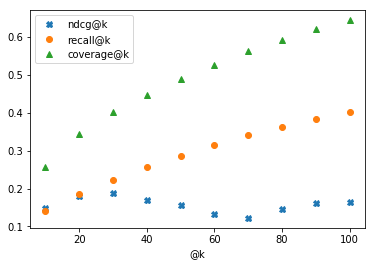

In [535]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,ndcg_vae,'X', label='ndcg@k')
line2, = ax.plot(krange,recall_vae,'o', label='recall@k')
line3, = ax.plot(krange,cov_vae,'^', label='coverage@k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

In [536]:
print("VAE trainning time: %f"%(vae_tr_time))
print("VAE testing time: %f"%(vae_te_time))


VAE trainning time: 44.015307
VAE testing time: 0.309174


# CF-KNN 

In [89]:
import surprise
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader

reader = Reader(line_format='user item rating', sep=',', skip_lines=3, rating_scale=(1, 5))
cf_dataset=pd.read_csv('../ml-latest-small/ratings.csv')
cf_dataset=cf_dataset.drop(['timestamp'],axis=1)

cf_data, user_fm, item_fm = filter_triplets(cf_dataset,min_sc = 5)
cf_data=Dataset.load_from_df(cf_data,reader=reader)


trainset, testset = train_test_split(cf_data, test_size=.2)
algo = KNNBaseline(k=80)

start = time.time()
algo.fit(trainset)
end = time.time()
knn_tr_time = end-start

start = time.time()
predict_test_knn = algo.test(testset)
end = time.time()
knn_te_time = end-start

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [90]:
from collections import defaultdict
def surprise_recall_at_k(predictions, k=10, threshold=4):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return recalls

def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est,true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def catalogcoverage(top_n):
    item_count = []
    for uid, user_ratings in top_n.items():
        top_k = [iid for (iid, _,_) in user_ratings]
        item_count.append(top_k)
    item_count = list(itertools.chain(*item_count))
    item_count = list(set(item_count))
    n_items = cf_dataset.movieId.unique().shape[0]
    cc = len(item_count)/n_items
    return cc
def ndcg_k(top_n, threshold=4):
    ndcg_values = []
    total_ndcg = 0.0
    best  = 0.0
    for uid, user_ratings in top_n.items():
        sum_ndcg = 0
        topk_tr = [iid for (iid,_,tr) in user_ratings if tr>=threshold]
        
        for i,x in enumerate(user_ratings):
            if x[0] in topk_tr:
                ndcg = 1/(math.log(i+2))
            else:
                ndcg = 0
            sum_ndcg += ndcg
        

        total_ndcg += sum_ndcg
        ndcg_values.append(sum_ndcg)

    ndcg_values = np.array(ndcg_values)
    max_ndcg = ndcg_values.max()
    ndcg_values = ndcg_values / max_ndcg 
    total_ndcg = np.sum(ndcg_values)

    return total_ndcg/float(len(ndcg_values))

In [91]:
recalls_test_20 = surprise_recall_at_k(predict_test_knn,20)
recall_test_20 = sum(rec for rec in recalls_test_20.values()) / len(recalls_test_20)
recalls_test_50 = surprise_recall_at_k(predict_test_knn,50)
recall_test_50 = sum(rec for rec in recalls_test_50.values()) / len(recalls_test_50)
catalogcoverage_20 = catalogcoverage(get_top_n(predict_test_knn,20))
catalogcoverage_50 = catalogcoverage(get_top_n(predict_test_knn,50))


print('Recall@20: test %.2f.' % (recall_test_20))
print('Recall@50: test %.2f.' % (recall_test_50))
print ('Catalog coverage@20: test %.2f.' % (catalogcoverage_20))
print ('Catalog coverage@50: test %.2f.' % (catalogcoverage_50))
print('NDCG@100: test %.2f.' % (ndcg_k(get_top_n(predict_test_knn,100))))

Recall@20: test 0.39.
Recall@50: test 0.41.
Catalog coverage@20: test 0.19.
Catalog coverage@50: test 0.27.
NDCG@100: test 0.26.


In [92]:
recall_knn,cov_knn,ndcg_knn=[],[],[]

for k in krange:
    recalls_test_k = surprise_recall_at_k(predict_test_knn,k)
    recall_test_k = sum(rec for rec in recalls_test_k.values()) / len(recalls_test_k)
    recall_knn.append(recall_test_k)
    cov_knn.append(catalogcoverage(get_top_n(predict_test_knn,k)))
    ndcg_knn.append(ndcg_k(get_top_n(predict_test_knn,k)))

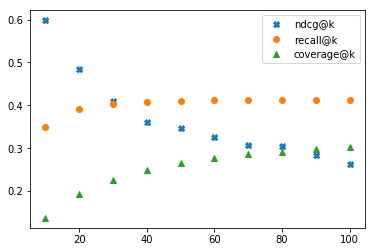

In [93]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,ndcg_knn,'X', label='ndcg@k')
line2, = ax.plot(krange,recall_knn,'o', label='recall@k')
line3, = ax.plot(krange,cov_knn,'^', label='coverage@k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

In [94]:
print("KNN trainning time: %f"%(knn_tr_time))
print("KNN testing time: %f"%(knn_te_time))

KNN trainning time: 0.351065
KNN testing time: 2.348719


# SVD++

In [95]:
from surprise import SVDpp
algo = SVDpp(lr_all = 0.011, reg_all = 0.1)


start = time.time()
algo.fit(trainset)
end = time.time()
svd_tr_time = end-start

start = time.time()
predict_test_svd = algo.test(testset)
end = time.time()
svd_te_time = end-start

In [96]:
recalls_test_20 = surprise_recall_at_k(predict_test_svd,20)
recall_test_20 = sum(rec for rec in recalls_test_20.values()) / len(recalls_test_20)
recalls_test_50 = surprise_recall_at_k(predict_test_svd,50)
recall_test_50 = sum(rec for rec in recalls_test_50.values()) / len(recalls_test_50)
catalogcoverage_20 = catalogcoverage(get_top_n(predict_test_svd,20))
catalogcoverage_50 = catalogcoverage(get_top_n(predict_test_svd,50))
print('Recall@20: test %.2f.' % (recall_test_20))
print('Recall@50: test %.2f.' % (recall_test_50))
print ('Catalog coverage@20: test %.2f.' % (catalogcoverage_20))
print ('Catalog coverage@50: test %.2f.' % (catalogcoverage_50))
print('NDCG@100: test %.2f.' % (ndcg_k(get_top_n(predict_test_svd,100))))

Recall@20: test 0.35.
Recall@50: test 0.37.
Catalog coverage@20: test 0.19.
Catalog coverage@50: test 0.26.
NDCG@100: test 0.24.


In [97]:
recall_svd,cov_svd,ndcg_svd=[],[],[]

for k in krange:
    recalls_test_k = surprise_recall_at_k(predict_test_svd,k)
    recall_test_k = sum(rec for rec in recalls_test_k.values()) / len(recalls_test_k)
    recall_svd.append(recall_test_k)
    cov_svd.append(catalogcoverage(get_top_n(predict_test_svd,k)))
    ndcg_svd.append(ndcg_k(get_top_n(predict_test_svd,k)))

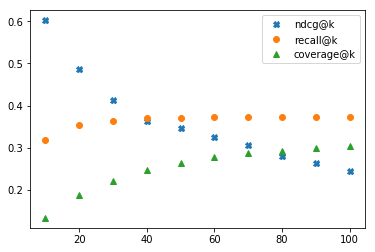

In [98]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,ndcg_svd,'X', label='ndcg@k')

line2, = ax.plot(krange,recall_svd,'o', label='recall@k')
line3, = ax.plot(krange,cov_svd,'^', label='coverage@k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

In [99]:
print("SVD trainning time: %f"%(svd_tr_time))
print("SVD testing time: %f"%(svd_te_time))

SVD trainning time: 422.458627
SVD testing time: 6.720007


## compare recall of 3 models

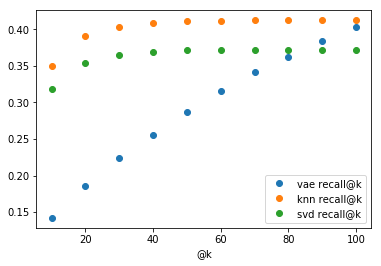

In [537]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,recall_vae,'o', label='vae recall@k')
line2, = ax.plot(krange,recall_knn,'o', label='knn recall@k')
line3, = ax.plot(krange,recall_svd,'o', label='svd recall@k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

## compare coverage

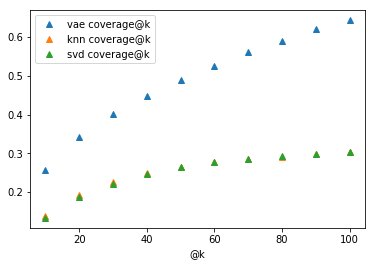

In [538]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,cov_vae,'^', label='vae coverage@k')
line2, = ax.plot(krange,cov_knn,'^', label='knn coverage@k')
line3, = ax.plot(krange,cov_svd,'^', label='svd coverage@k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

## compare NDCG

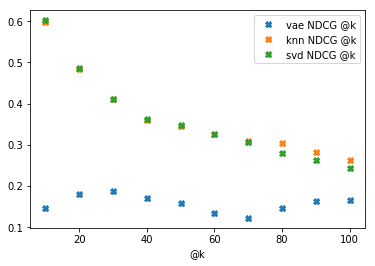

In [539]:
fig, ax = plt.subplots()
line1, = ax.plot(krange,ndcg_vae,'X', label='vae NDCG @k')
line2, = ax.plot(krange,ndcg_knn,'X', label='knn NDCG @k')
line3, = ax.plot(krange,ndcg_svd,'X', label='svd NDCG @k')
ax.set_xlabel('@k')

ax.legend()

plt.show()

## compare running time

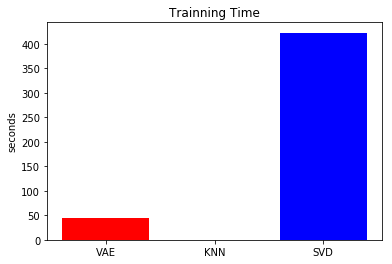

In [540]:
fig, ax = plt.subplots()
ind = np.arange(1, 4)
pm, pc, pn = plt.bar(ind, [vae_tr_time,knn_tr_time,svd_tr_time])
pm.set_facecolor('r')
pc.set_facecolor('g')
pn.set_facecolor('b')
ax.set_xticks(ind)
ax.set_xticklabels(['VAE', 'KNN', 'SVD'])
ax.set_ylabel('seconds')
ax.set_title('Trainning Time')

plt.show()

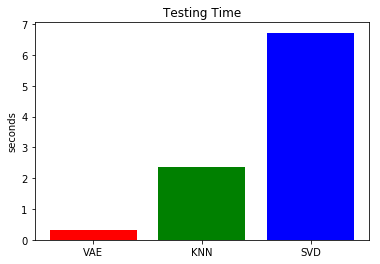

In [541]:
fig, ax = plt.subplots()
ind = np.arange(1, 4)
pm, pc, pn = plt.bar(ind, [vae_te_time,knn_te_time,svd_te_time])
pm.set_facecolor('r')
pc.set_facecolor('g')
pn.set_facecolor('b')
ax.set_xticks(ind)
ax.set_xticklabels(['VAE', 'KNN', 'SVD'])
ax.set_ylabel('seconds')
ax.set_title('Testing Time')

plt.show()

## compare recommendation result

In [542]:
movies = pd.read_csv('../ml-latest-small/movies.csv')


In [543]:
k = 20

In [569]:
x_train_reconstructed = vae.predict(train, batch_size=batch_size)

top 20 movies by a random user

In [570]:
random_uid = np.random.choice(raw_data.userId.unique(),1)[0]

In [571]:
vae_id = profile2id[random_uid]

titles= movies.loc[movies.movieId.isin(unique_sid[np.argsort(np.array(np.squeeze(train.todense()))[vae_id])[-k-1:]])].title.values


True top 20

In [572]:
print('For userId %d Top %d movies are:'%(random_uid,k))
for title in titles:
    print(title)

For userId 114 Top 20 movies are:
GoldenEye (1995)
Edward Scissorhands (1990)
Bridget Jones's Diary (2001)
Princess Diaries, The (2001)
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Royal Tenenbaums, The (2001)
Gosford Park (2001)
I Am Sam (2001)
Monster's Ball (2001)
Sandlot, The (1993)
My Big Fat Greek Wedding (2002)
Star Wars: Episode II - Attack of the Clones (2002)
Insomnia (2002)
Jackass: The Movie (2002)
Harry Potter and the Chamber of Secrets (2002)
Holes (2003)
Harry Potter and the Prisoner of Azkaban (2004)
Spider-Man 2 (2004)
Spider-Man 3 (2007)
Harry Potter and the Order of the Phoenix (2007)
Wolf of Wall Street, The (2013)


VAE recommend

In [573]:

vae_movie_id = unique_sid[np.argsort(x_train_reconstructed[vae_id])[-k-1:]]

vae_titles = movies.loc[movies.movieId.isin(vae_movie_id)].title.values

print('For userId %d Top %d movies VAE recommend are:'%(random_uid,k))
for title in vae_titles:
    print(title)

For userId 114 Top 20 movies VAE recommend are:
Braveheart (1995)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Pulp Fiction (1994)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Schindler's List (1993)
Saving Private Ryan (1998)
Edward Scissorhands (1990)
Matrix, The (1999)
Fight Club (1999)
Gladiator (2000)
Memento (2000)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Star Wars: Episode II - Attack of the Clones (2002)
Lord of the Rings: The Two Towers, The (2002)
Harry Potter and the Prisoner of Azkaban (2004)
300 (2007)
WALL·E (2008)
Watchmen (2009)
Gran Torino (2008)
Avatar (2009)


KNN recommend

In [574]:
knn_top20 = get_top_n(predict_test_knn,20)[random_uid]

In [575]:
knn_mid=[]
for x in knn_top20:
    knn_mid.append(x[0])

In [576]:
knn_titles = movies.loc[movies.movieId.isin(knn_mid)].title.values

print('For userId %d Top %d movies KNN recommend are:'%(random_uid,k))
for title in knn_titles:
    print(title)

For userId 114 Top 20 movies KNN recommend are:
Star Wars: Episode IV - A New Hope (1977)
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Spider-Man (2002)
WALL·E (2008)
Zootopia (2016)


SVD recommend

In [579]:
svd_top20 = get_top_n(predict_test_svd,20)[random_uid]

In [580]:
svd_mid=[]
for x in svd_top20:
    svd_mid.append(x[0])

In [581]:
svd_titles = movies.loc[movies.movieId.isin(svd_mid)].title.values

print('For userId %d Top %d movies SVD recommend are:'%(random_uid,k))
for title in svd_titles:
    print(title)

For userId 114 Top 20 movies SVD recommend are:
Star Wars: Episode IV - A New Hope (1977)
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Spider-Man (2002)
WALL·E (2008)
Zootopia (2016)


In [577]:
# true_movie_id = raw_data[raw_data.userId==random_uid].sort_values(by = ['rating']).movieId.values[::-1][:k]

# titles = movies.loc[movies.movieId.isin(true_movie_id)].title.values
